# Planet: Understanding the Amazon deforestation from Space challenge

Special thanks to the kernel contributors of this challenge (especially @anokas and @Kaggoo) who helped me find a starting point for this notebook.

The whole code including the `data_helper.py` and `keras_helper.py` files are available on github [here](https://github.com/EKami/planet-amazon-deforestation) and the notebook can be found on the same github [here](https://github.com/EKami/planet-amazon-deforestation/blob/master/notebooks/amazon_forest_notebook.ipynb)

**If you found this notebook useful some upvotes would be greatly appreciated! :) **

Start by adding the helper files to the python path

In [1]:
import sys

sys.path.append('../src')
sys.path.append('../tests')

## Import required modules

In [2]:
import os
import gc
import bcolz
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, History
import vgg16
import data_helper
from data_helper import AmazonPreprocessor
#from kaggle_data.downloader import KaggleDataDownloader

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


Print tensorflow version for reuse (the Keras module is used directly from the tensorflow framework)

In [3]:
tf.__version__

'1.3.0'

## Download the competition files
Download the dataset files and extract them automatically with the help of [Kaggle data downloader](https://github.com/EKami/kaggle-data-downloader)

In [4]:
competition_name = "planet-understanding-the-amazon-from-space"

train, train_u = "train-jpg.tar.7z", "train-jpg.tar"
test, test_u = "test-jpg.tar.7z", "test-jpg.tar"
test_additional, test_additional_u = "test-jpg-additional.tar.7z", "test-jpg-additional.tar"
test_labels = "train_v2.csv.zip"
destination_path = "../input/"
is_datasets_present = False

# If the folders already exists then the files may already be extracted
# This is a bit hacky but it's sufficient for our needs
datasets_path = data_helper.get_jpeg_data_files_paths()
for dir_path in datasets_path:
    if os.path.exists(dir_path):
        is_datasets_present = True

if not is_datasets_present:
    # Put your Kaggle user name and password in a $KAGGLE_USER and $KAGGLE_PASSWD env vars respectively
    downloader = KaggleDataDownloader(os.getenv("KAGGLE_USER"), os.getenv("KAGGLE_PASSWD"), competition_name)
    
    train_output_path = downloader.download_dataset(train, destination_path)
    downloader.decompress(train_output_path, destination_path) # Outputs a tar file
    downloader.decompress(destination_path + train_u, destination_path) # Extract the content of the previous tar file
    os.remove(train_output_path) # Removes the 7z file
    os.remove(destination_path + train_u) # Removes the tar file
    
    test_output_path = downloader.download_dataset(test, destination_path)
    downloader.decompress(test_output_path, destination_path) # Outputs a tar file
    downloader.decompress(destination_path + test_u, destination_path) # Extract the content of the previous tar file
    os.remove(test_output_path) # Removes the 7z file
    os.remove(destination_path + test_u) # Removes the tar file
    
    test_add_output_path = downloader.download_dataset(test_additional, destination_path)
    downloader.decompress(test_add_output_path, destination_path) # Outputs a tar file
    downloader.decompress(destination_path + test_additional_u, destination_path) # Extract the content of the previous tar file
    os.remove(test_add_output_path) # Removes the 7z file
    os.remove(destination_path + test_additional_u) # Removes the tar file
    
    test_labels_output_path = downloader.download_dataset(test_labels, destination_path)
    downloader.decompress(test_labels_output_path, destination_path) # Outputs a csv file
    os.remove(test_labels_output_path) # Removes the zip file
else:
    print("All datasets are present.")

## Inspect image labels
Visualize what the training set looks like

In [4]:
train_jpeg_dir, test_jpeg_dir, test_jpeg_additional, train_csv_file = data_helper.get_jpeg_data_files_paths()
labels_df = pd.read_csv(train_csv_file)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


Each image can be tagged with multiple tags, lets list all uniques tags

In [5]:
# Print all unique tags
from itertools import chain
labels_list = list(chain.from_iterable([tags.split(" ") for tags in labels_df['tags'].values]))
labels_set = set(labels_list)
print("There is {} unique labels including {}".format(len(labels_set), labels_set))

There is 17 unique labels including set(['slash_burn', 'clear', 'blooming', 'primary', 'cloudy', 'conventional_mine', 'water', 'haze', 'cultivation', 'partly_cloudy', 'artisinal_mine', 'habitation', 'bare_ground', 'blow_down', 'agriculture', 'road', 'selective_logging'])


### Repartition of each labels

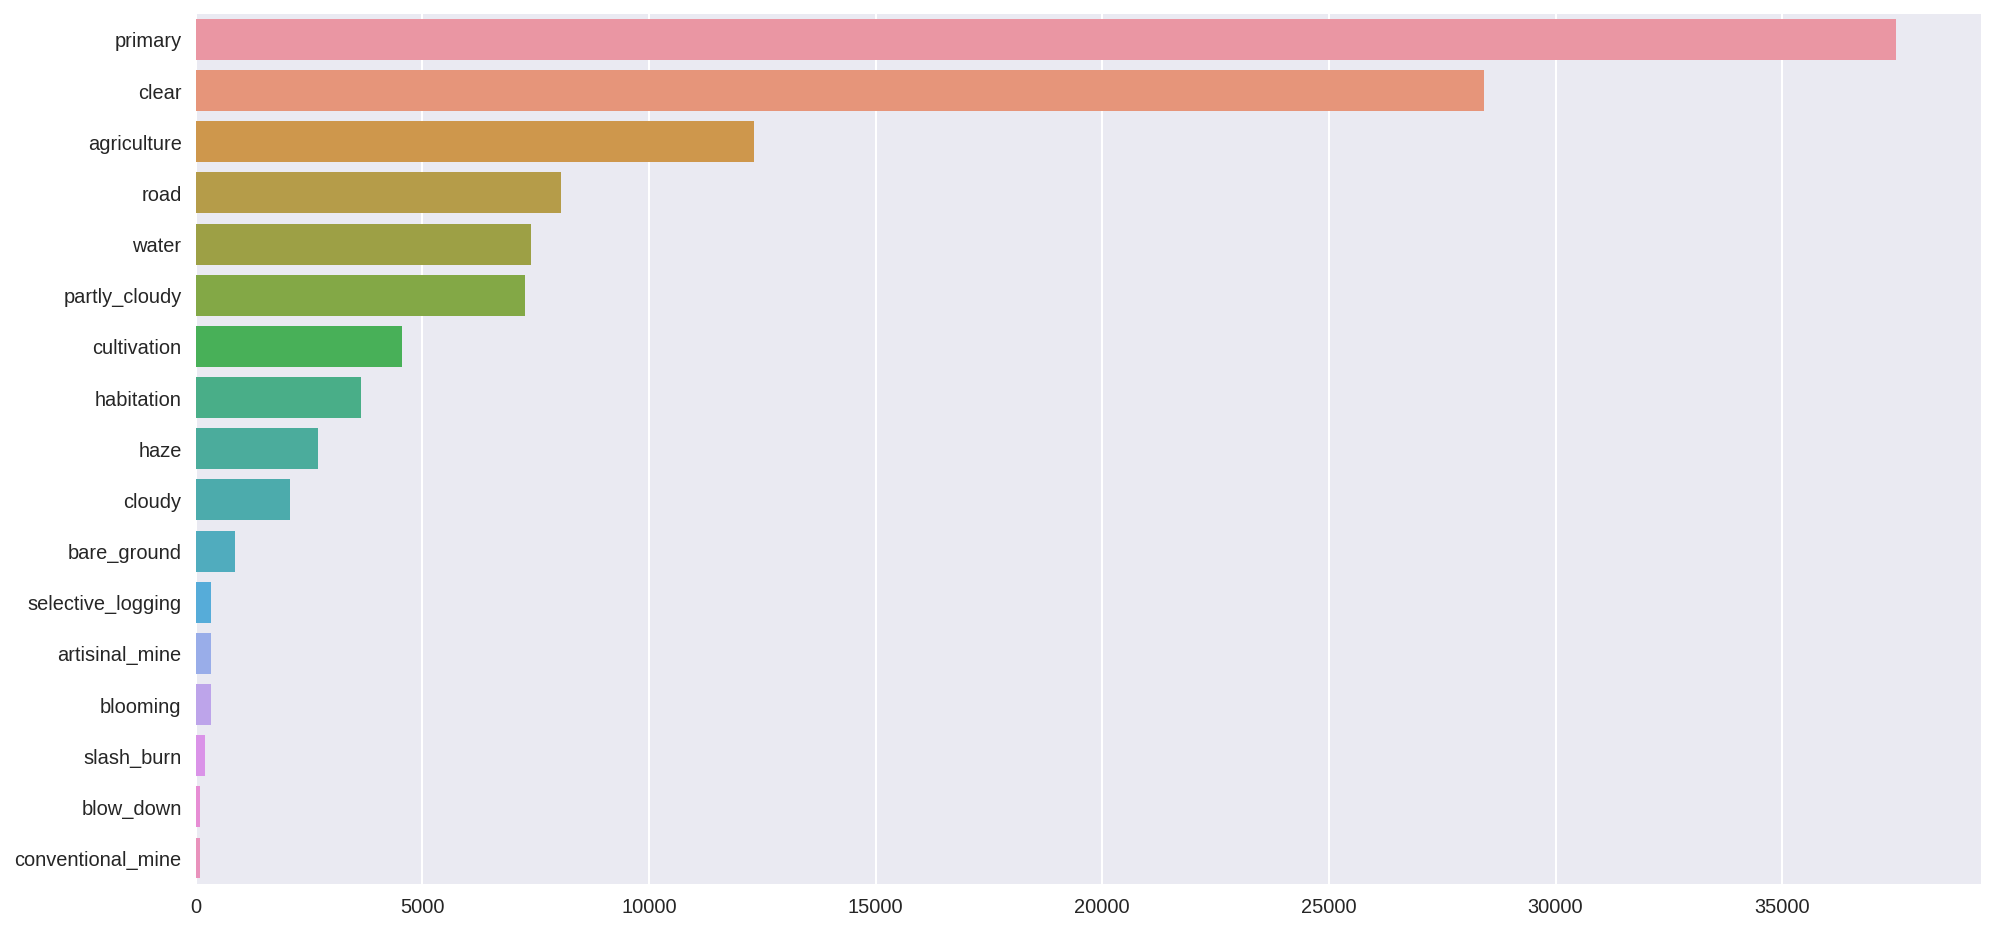

In [6]:
# Histogram of label instances
labels_s = pd.Series(labels_list).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s, y=labels_s.index, orient='h')

## Images
Visualize some chip images to know what we are dealing with.
Lets vizualise 1 chip for the 17 images to get a sense of their differences.

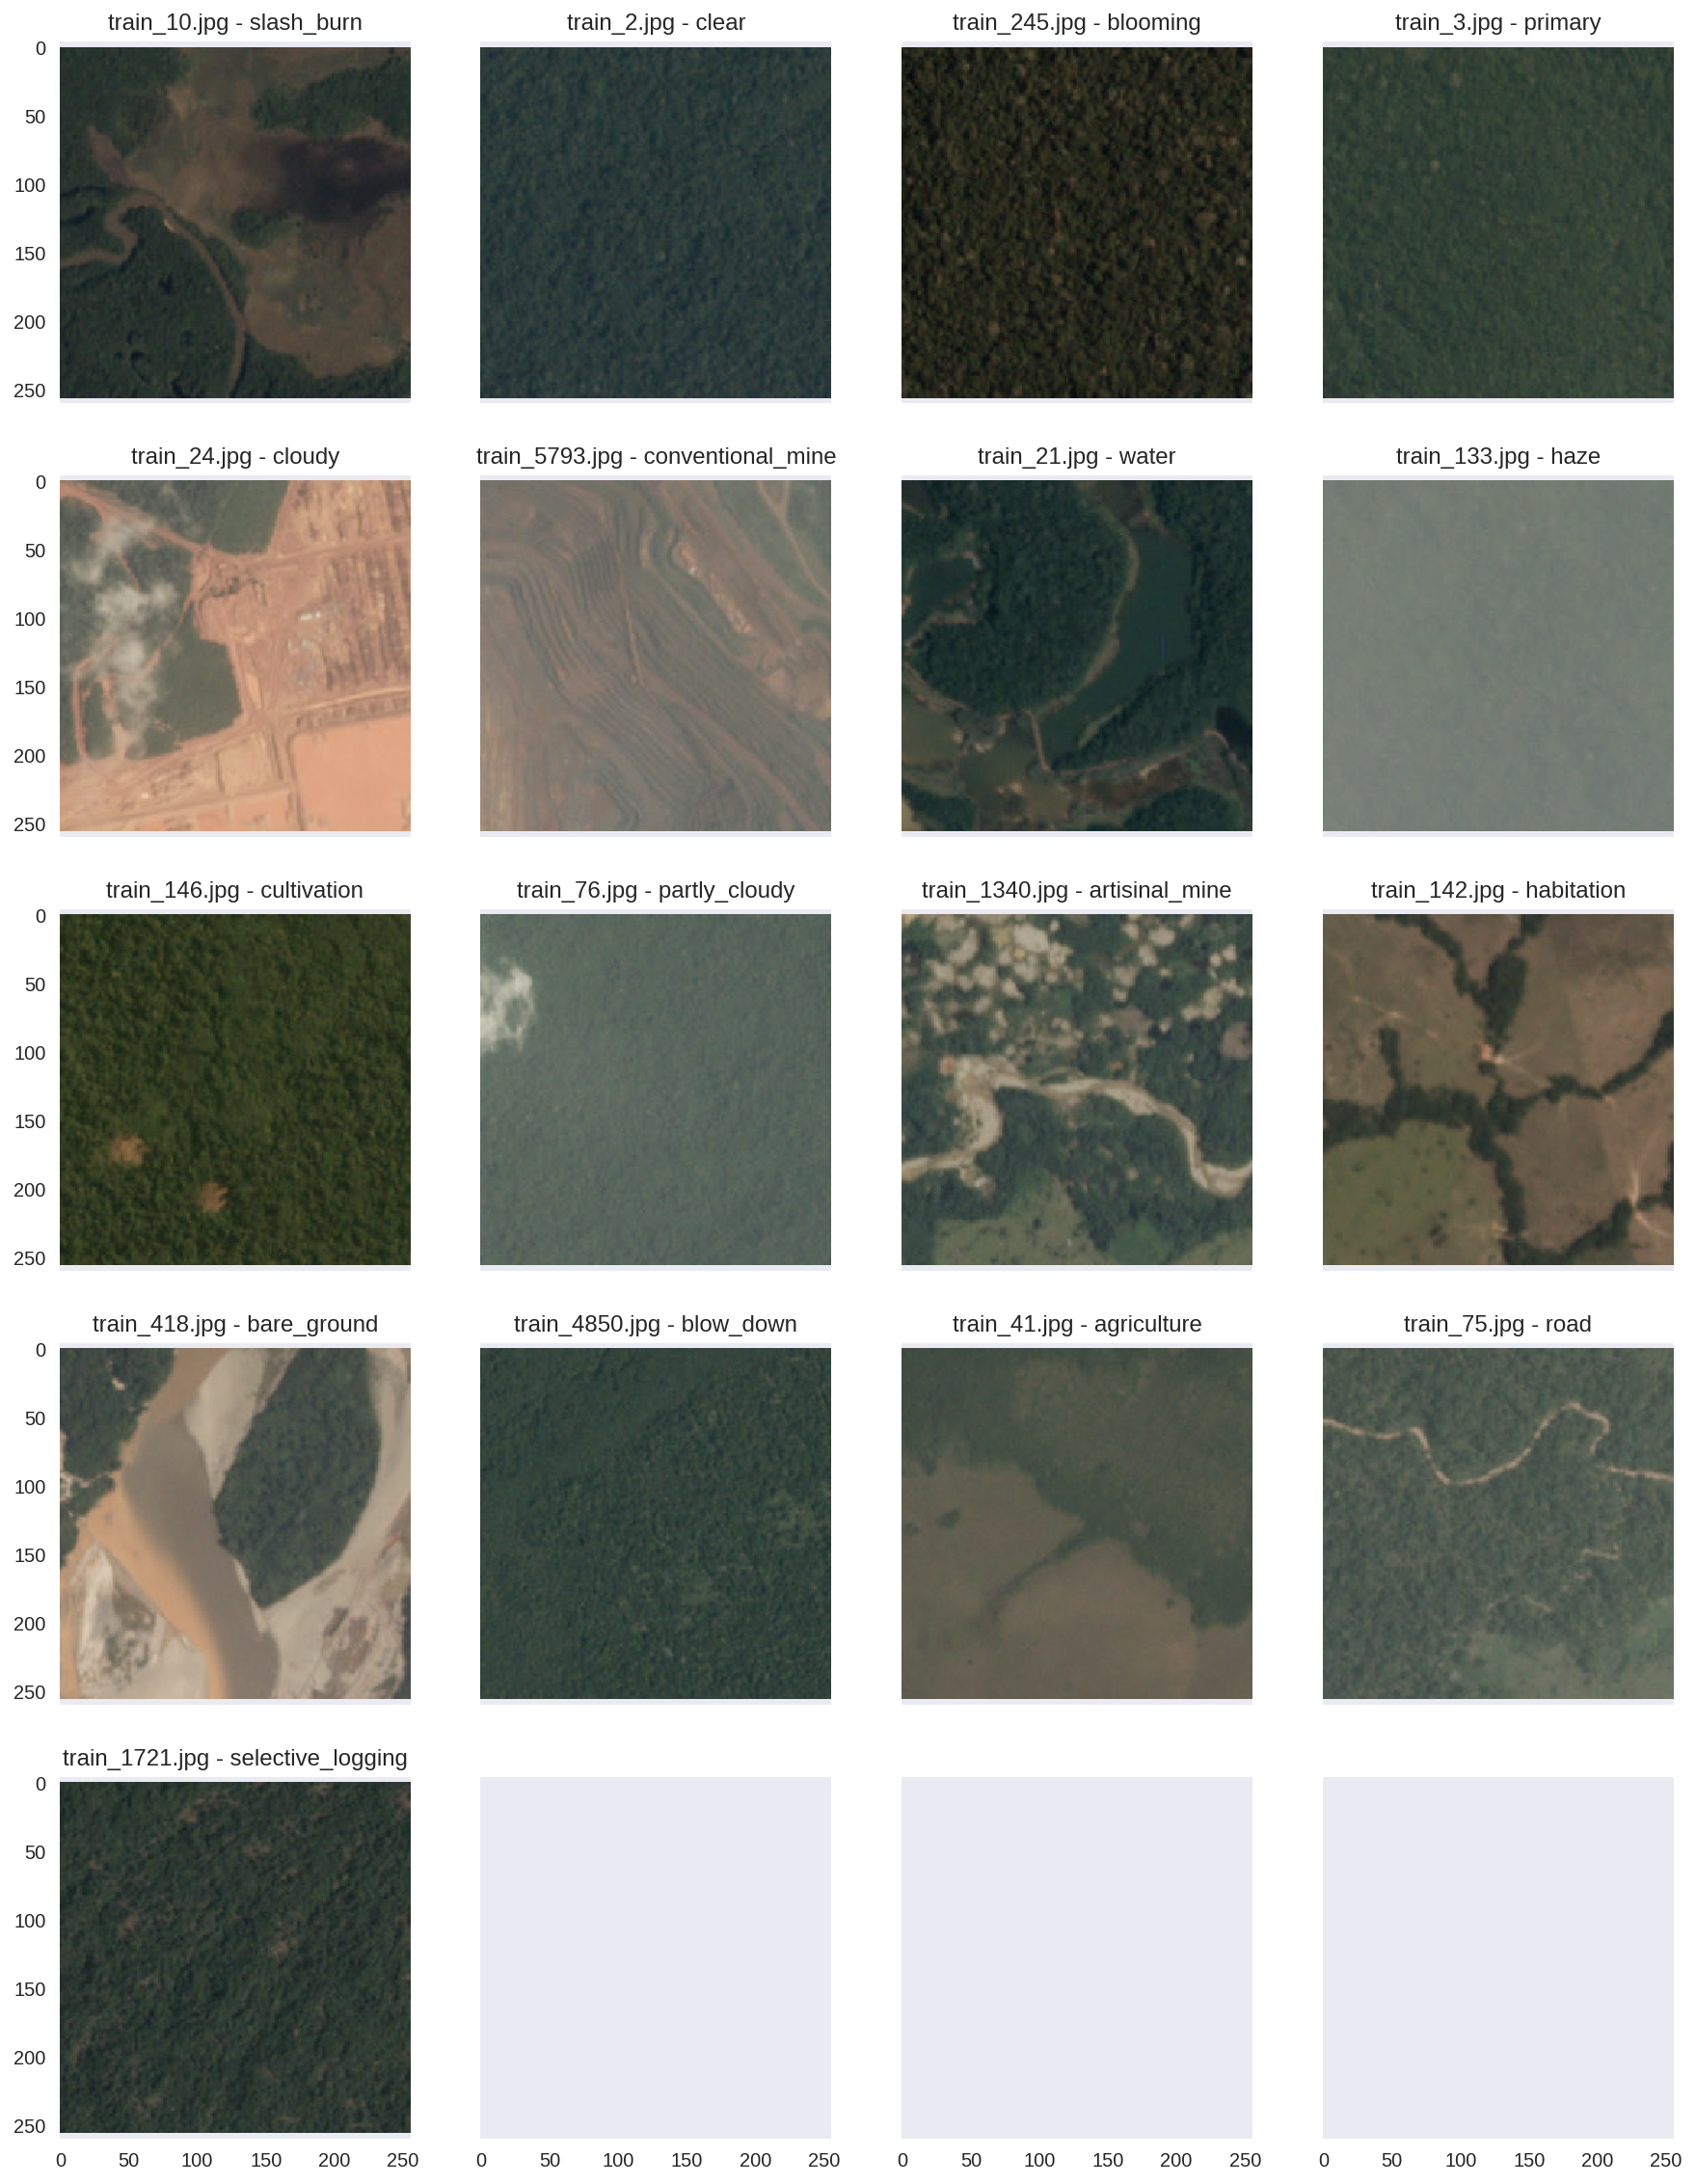

In [7]:
images_title = [labels_df[labels_df['tags'].str.contains(label)].iloc[i]['image_name'] + '.jpg' 
                for i, label in enumerate(labels_set)]

plt.rc('axes', grid=False)
_, axs = plt.subplots(5, 4, sharex='col', sharey='row', figsize=(15, 20))
axs = axs.ravel()

for i, (image_name, label) in enumerate(zip(images_title, labels_set)):
    img = mpimg.imread(train_jpeg_dir + '/' + image_name)
    axs[i].imshow(img)
    axs[i].set_title('{} - {}'.format(image_name, label))

# Image resize & validation split
Define the dimensions of the image data trained by the network. Recommended resized images could be 32x32, 64x64, or 128x128 to speedup the training. 

You could also use `None` to use full sized images.

Be careful, the higher the `validation_split_size` the more RAM you will consume.

In [8]:
img_resize = (64, 64) # The resize size of each image ex: (64, 64) or None to use the default image size
validation_split_size = 0.2

# Data preprocessing
Due to the hudge amount of memory the preprocessed images can take, we will create a dedicated `AmazonPreprocessor` class which job is to preprocess the data right in time at specific steps (training/inference) so that our RAM don't get completely filled by the preprocessed images. 

The only exception to this being the validation dataset as we need to use it as-is for f2 score calculation as well as when we calculate the validation accuracy of each batch.

In [9]:
preprocessor = AmazonPreprocessor(train_jpeg_dir, train_csv_file, test_jpeg_dir, test_jpeg_additional, 
                                  img_resize, validation_split_size)
preprocessor.init()

100%|██████████| 8096/8096 [00:00<00:00, 138841.76it/s]

Transforming val dataset...



100%|██████████| 8096/8096 [00:02<00:00, 3173.32it/s] 


Done. Size consumed by validation matrices 379 mb


In [10]:
print("X_train/y_train length: {}/{}".format(len(preprocessor.X_train), len(preprocessor.y_train)))
print("X_val/y_val length: {}/{}".format(len(preprocessor.X_val), len(preprocessor.y_val)))
print("X_test/X_test_filename length: {}/{}".format(len(preprocessor.X_test), len(preprocessor.X_test_filename)))
preprocessor.y_map

X_train/y_train length: 32383/32383
X_val/y_val length: 8096/8096
X_test/X_test_filename length: 61191/61191


{0: 'agriculture',
 1: 'artisinal_mine',
 2: 'bare_ground',
 3: 'blooming',
 4: 'blow_down',
 5: 'clear',
 6: 'cloudy',
 7: 'conventional_mine',
 8: 'cultivation',
 9: 'habitation',
 10: 'haze',
 11: 'partly_cloudy',
 12: 'primary',
 13: 'road',
 14: 'selective_logging',
 15: 'slash_burn',
 16: 'water'}

# Funetuning

Here we define the model for finetuning

In [11]:
model = vgg16.create_model(img_dim=(64, 64, 3))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 3)         12        
_________________________________________________________________
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 17)                34833     
Total params: 14,749,533
Trainable params: 14,749,527
Non-trainable params: 6
_________________________________________________________________


## Fine-tune conv layers
We will now finetune all layers in the VGG16 model. 

In [12]:
history = History()
callbacks = [history, 
             EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, cooldown=0, min_lr=1e-7, verbose=1),
             ModelCheckpoint(filepath='weights/weights.best.hdf5', verbose=1, save_best_only=True, 
                             save_weights_only=True, mode='auto')]

X_train, y_train = preprocessor.X_train, preprocessor.y_train
X_val, y_val = preprocessor.X_val, preprocessor.y_val

batch_size = 128
train_generator = preprocessor.get_train_generator(batch_size)
steps = len(X_train) / batch_size

model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics = ['accuracy'])
history = model.fit_generator(train_generator, steps, epochs=25, verbose=1, 
                    validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/25


Exception in thread Thread-20:
Traceback (most recent call last):
  File "/home/mcisaac/anaconda2/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/mcisaac/anaconda2/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "/home/mcisaac/anaconda2/lib/python2.7/site-packages/keras/engine/training.py", line 612, in data_generator_task
    generator_output = next(self._generator)
  File "../src/data_helper.py", line 96, in get_train_generator
    batch_features = np.zeros((range_offset, self.img_resize, 3))
TypeError: 'tuple' object cannot be interpreted as an index



ValueError: output of generator should be a tuple `(x, y, sample_weight)` or `(x, y)`. Found: None

## Visualize Loss Curve

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Load Best Weights

In [15]:
model.load_weights("weights/weights.best.hdf5")
print("Weights loaded")

## Check Fbeta Score

In [16]:
fbeta_score = vgg16.fbeta(model, X_val, y_val)

fbeta_score

## Make predictions

In [17]:
predictions, x_test_filename = vgg16.predict(model, preprocessor, batch_size=128)
print("Predictions shape: {}\nFiles name shape: {}\n1st predictions ({}) entry:\n{}".format(predictions.shape, 
                                                                              x_test_filename.shape,
                                                                              x_test_filename[0], predictions[0]))

Before mapping our predictions to their appropriate labels we need to figure out what threshold to take for each class

In [18]:
thresholds = [0.2] * len(labels_set)

Now lets map our predictions to their tags by using the thresholds

In [19]:
predicted_labels = vgg16.map_predictions(preprocessor, predictions, thresholds)

Finally lets assemble and visualize our predictions for the test dataset

In [20]:
tags_list = [None] * len(predicted_labels)
for i, tags in enumerate(predicted_labels):
    tags_list[i] = ' '.join(map(str, tags))

final_data = [[filename.split(".")[0], tags] for filename, tags in zip(x_test_filename, tags_list)]

In [21]:
final_df = pd.DataFrame(final_data, columns=['image_name', 'tags'])
print("Predictions rows:", final_df.size)
final_df.head()

In [22]:
tags_s = pd.Series(list(chain.from_iterable(predicted_labels))).value_counts()
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=tags_s, y=tags_s.index, orient='h');

If there is a lot of `primary` and `clear` tags, this final dataset may be legit...

And save it to a submission file

In [23]:
final_df.to_csv('../submission_file.csv', index=False)

#### That's it, we're done!